In [18]:
import osmnx as ox # OpenStreetMap: biblioteca de mapas
import networkx as nx # para trabalhar com grafos
import folium # para criar mapas interativos
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

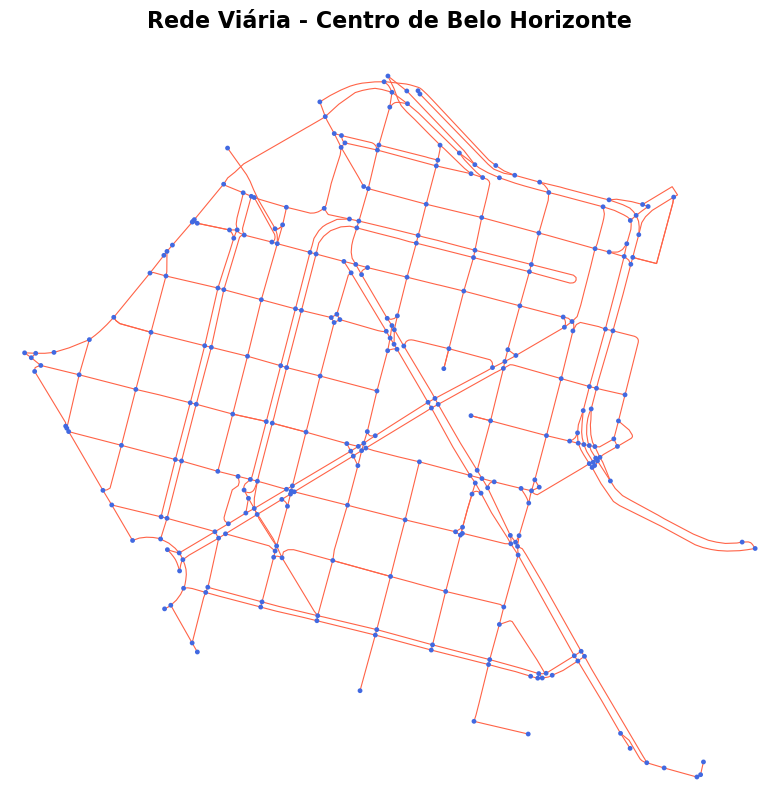

In [2]:
### Primeiro vamos gerar um grafo a partir do mapa de uma região ###

# Definindo a região escolhida
regiao = "Centro, Belo Horizonte, Minas Gerais, Brazil"

# Fazer download do grafo real da região 
G = ox.graph_from_place(regiao, network_type="drive")

# vamos plotar o grafo obtido
fig, ax = ox.plot_graph(
    G,
    node_size=12,
    node_color="royalblue",
    edge_color="tomato",
    bgcolor="white",
    edge_linewidth=0.8,
    show=False,   
    close=False,  
)

ax.set_title(
    "Rede Viária - Centro de Belo Horizonte",
    fontsize=16,
    fontweight="bold",
    color="black",
    pad=25,
)

plt.tight_layout()
plt.subplots_adjust(top=0.93)

plt.show()


In [3]:
### Vamos criar um mapa interativo ###

# Vamos extrair os nós e as arestas
nodes, edges = ox.graph_to_gdfs(G)

# para centralizar o mapa
centro = [nodes.geometry.y.mean(), nodes.geometry.x.mean()]

# Crie o mapa base com a biblioteca Folium
m = folium.Map(location=centro, zoom_start=14, tiles="cartodbpositron")

# Adicionando as arestas (ruas)
for _, row in edges.iterrows():
    pontos = [(y, x) for x, y in row.geometry.coords]
    folium.PolyLine(pontos, color="gray", weight=2, opacity=0.8).add_to(m)

# Adicionando os nós (interseções)
for _, row in nodes.iterrows():
    folium.CircleMarker(
        location=(row.geometry.y, row.geometry.x),
        radius=2,
        color="red",
        fill=True,
        fill_color="red",
        fill_opacity=0.7
    ).add_to(m)

# Salva o mapa 
m.save("mapa.html")

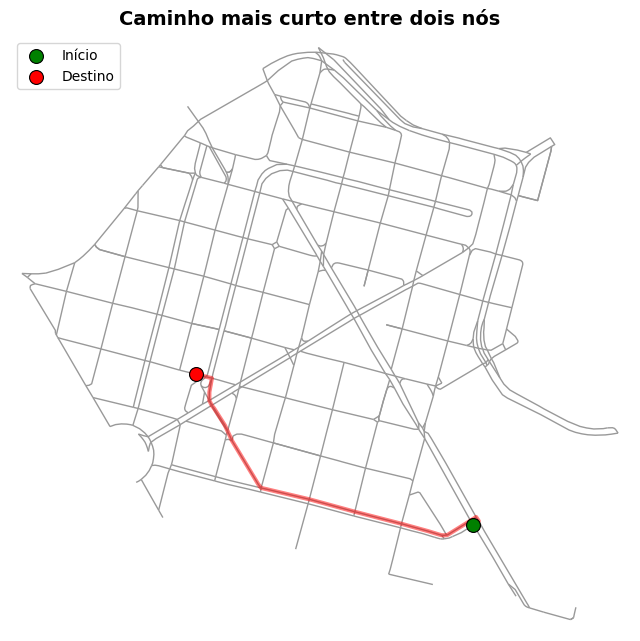

In [4]:
### Vamos fazer a rota entre dois pontos do mapa ###

# Vamos escolher dois nós aleatórios
nos = list(G.nodes())
no_origem = np.random.choice(nos)
no_destino = np.random.choice(nos)
while no_destino == no_origem:
    no_destino = np.random.choice(nos)


# Vamos o caminho mais curto com base na distância (atributo 'length')
caminho = nx.shortest_path(G, source=no_origem, target=no_destino, weight='length')

# Plotando o grafo com o caminho destacado
fig, ax = ox.plot_graph_route(
    G,
    caminho,
    route_color="red",
    route_linewidth=3,
    node_size=0,
    bgcolor="white",
    show=False,
    close=False
)

# Coordenadas dos nós
origem = G.nodes[no_origem]
destino = G.nodes[no_destino]

# Plotando os pontos iniciais e finais
ax.scatter(origem['x'], origem['y'], c='green', s=100, zorder=5, label='Início', edgecolors='black', linewidth=0.8)
ax.scatter(destino['x'], destino['y'], c='red', s=100, zorder=5, label='Destino', edgecolors='black', linewidth=0.8)

# Legenda e título
ax.legend(loc='upper left')
fig.suptitle(
    f"Caminho mais curto entre dois nós",
    fontsize=14,
    fontweight='bold',
    y=0.90
)
plt.show()


In [5]:
### Vamos saber as ruas percorridas no trajeto mais curto ###

ruas = []
for u, v, data in zip(caminho[:-1], caminho[1:], [G[u][v][0] for u, v in zip(caminho[:-1], caminho[1:])]):
    ruas.append(data.get('name'))
    

print("A rua inicial:", ruas[0])
print("A rua final:", ruas[-1])
print("A rota completa", ruas)

A rua inicial: Avenida Álvares Cabral
A rua final: Rua dos Tupis
A rota completa ['Avenida Álvares Cabral', 'Avenida Afonso Pena', 'Avenida Álvares Cabral', 'Avenida Álvares Cabral', 'Avenida Álvares Cabral', 'Avenida Augusto de Lima', 'Avenida Augusto de Lima', 'Avenida Augusto de Lima', 'Avenida Augusto de Lima', 'Rua Padre Belchior', 'Rua Padre Belchior', 'Rua Padre Belchior', 'Avenida Paraná', 'Avenida Paraná', 'Rua dos Tupis', 'Rua dos Tupis']


In [6]:
### funções para uma análise da rede

# Função que conta os links de cada nó da rede
def contar_link(rede): 
    N = np.max(rede) + 1 # N é números de nós da rede 
    links = np.zeros(N) # a entrada do array tem a quantidade de link do nó correspondente a entrada
    for l in rede:
        for n in l:
            links[n] += 1
    return links
    
    
# Função que cria a lista de adjacencias de uma rede
def adjacencia(rede):
    graus = contar_link(rede)
    t_lista = int(np.sum(graus))
    lista_adj = np.zeros(t_lista)
    n_max = np.max(rede) # quantidade de nós
    i = 0 # índice lista adjacências
    for n in range(n_max + 1):
        for k in range(len(rede)):
            no_1 = rede[k][0]
            no_2 = rede[k][1]
            if no_1 == n:
                lista_adj[i] = no_2
                i += 1
            if no_2 == n:
                lista_adj[i] = no_1
                i +=1
    return lista_adj



# Função que retorna o vizinhos de um nó
def vizinho_no(n, graus_rede, lista_adj_rede): # n representa o nó
    inicio = 0
    for t in range(int(n)):
        inicio += int(graus_rede[t])
    n_vizinhos = int(graus_rede[n])
    lista_vizinhos_no = np.zeros(n_vizinhos)
    for j in range(n_vizinhos):
        lista_vizinhos_no[j] = lista_adj_rede[inicio]
        inicio += 1
    return lista_vizinhos_no



# Função que verifica se um determinado nó pertence à uma lista
# se pertencer, a função retorna -1
# se não pertencer, a função retorna -2
def verifica(no_dado, lista):
    for no in lista:
        if no == no_dado:
            return -1
    return -2



### Função que calcula o comprimento do caminho mais curto entre o no_i e o no_j 
# usando o metodo BFS
## também retorna a 'queue'
def menor_distancia(no_i, no_j, lista_adj, graus_rede):
    no_i = int(no_i)
    no_j = int(no_j)
    queue = [[no_i]]
    visitados = [no_i]
    while True:
        ultimos = queue[-1]  # camada atual
        # Verifica se o nó destino está nessa camada
        if verifica(no_j, ultimos) != -2:
            break
        vizinhos = []
        for no in ultimos:
            no = int(no) 
            v_no = vizinho_no(no, graus_rede, lista_adj)
            for n in v_no:
                n = int(n)  
                if verifica(n, visitados) == -2:
                    vizinhos.append(n)
                    visitados.append(n)
        queue.append(vizinhos)
    j = len(queue) - 1  # comprimento do caminho
    return int(j), queue



### Função que retorna a matriz distância D da rede
def Matriz_D(N, lista_adj, graus_rede):
    D = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            d, Q = menor_distancia(i, j, lista_adj, graus_rede)
            if i == j:
                D[i, j] = 0
            else:
                D[i, j] = d
                D[j, i] = d
    return D


In [55]:
### Algumas informações do grafo obtido ###
print(nx.info(G))

MultiDiGraph with 296 nodes and 495 edges


/tmp/ipykernel_402041/2468406665.py:2: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G))


In [16]:
### Análise da rede ###

# Para poder trabalhar nas medidas da rede, vamos extrair a lista de conexões
rede = list(G.edges())

# Cria um mapeamento
mapa_nos = {no: i for i, no in enumerate(G.nodes())}

# Converte a lista de arestas para usar índices pequenos e sequencial
rede_convertida = np.array([[mapa_nos[u], mapa_nos[v]] for u, v in rede])


N = len(mapa_nos) #número de nós

graus_rede = contar_link(rede_convertida) # calcula o grau de cada nó da rede
lista_adj = adjacencia(rede_convertida) # cria a lista de adjacências da rede
matriz_D = Matriz_D(N, lista_adj, graus_rede) # calcula a matriz distancias da rede


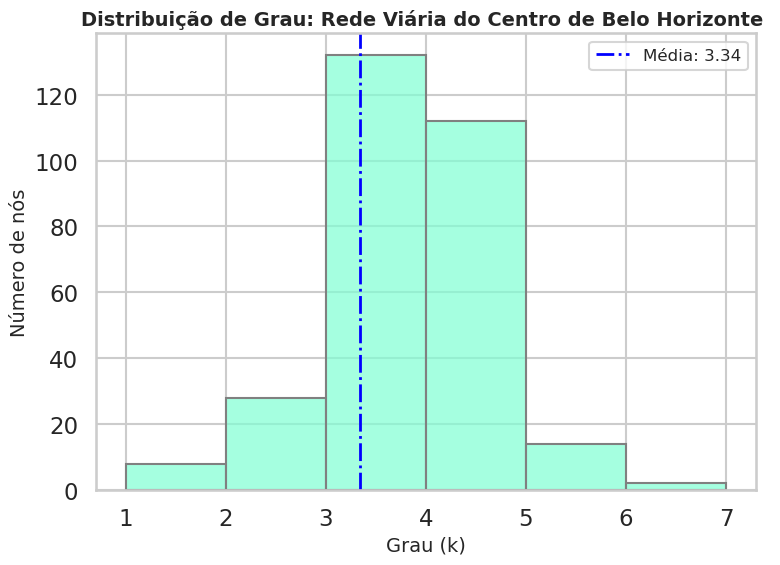

In [54]:
# Histograma com o grau de cada nó
sns.set(style="whitegrid", context="talk")

graus = np.array(graus_rede)
mediana = np.median(graus)
media = np.mean(graus)

# Cria o histograma
plt.figure(figsize=(8, 6))
sns.histplot(graus, bins=range(int(graus.min()), int(graus.max()) + 2),
             color="aquamarine", edgecolor="gray", alpha=0.7, kde=False)

plt.title("Distribuição de Grau: Rede Viária do Centro de Belo Horizonte ", fontsize=14, weight='bold')
plt.xlabel("Grau (k)", fontsize=14)
plt.ylabel("Número de nós", fontsize=14)

# Linhas de referência

plt.axvline(media, color='blue', linestyle='-.', linewidth=2,
            label=f"Média: {media:.2f}")

plt.legend(frameon=True, fontsize=12)
plt.tight_layout()
plt.show()


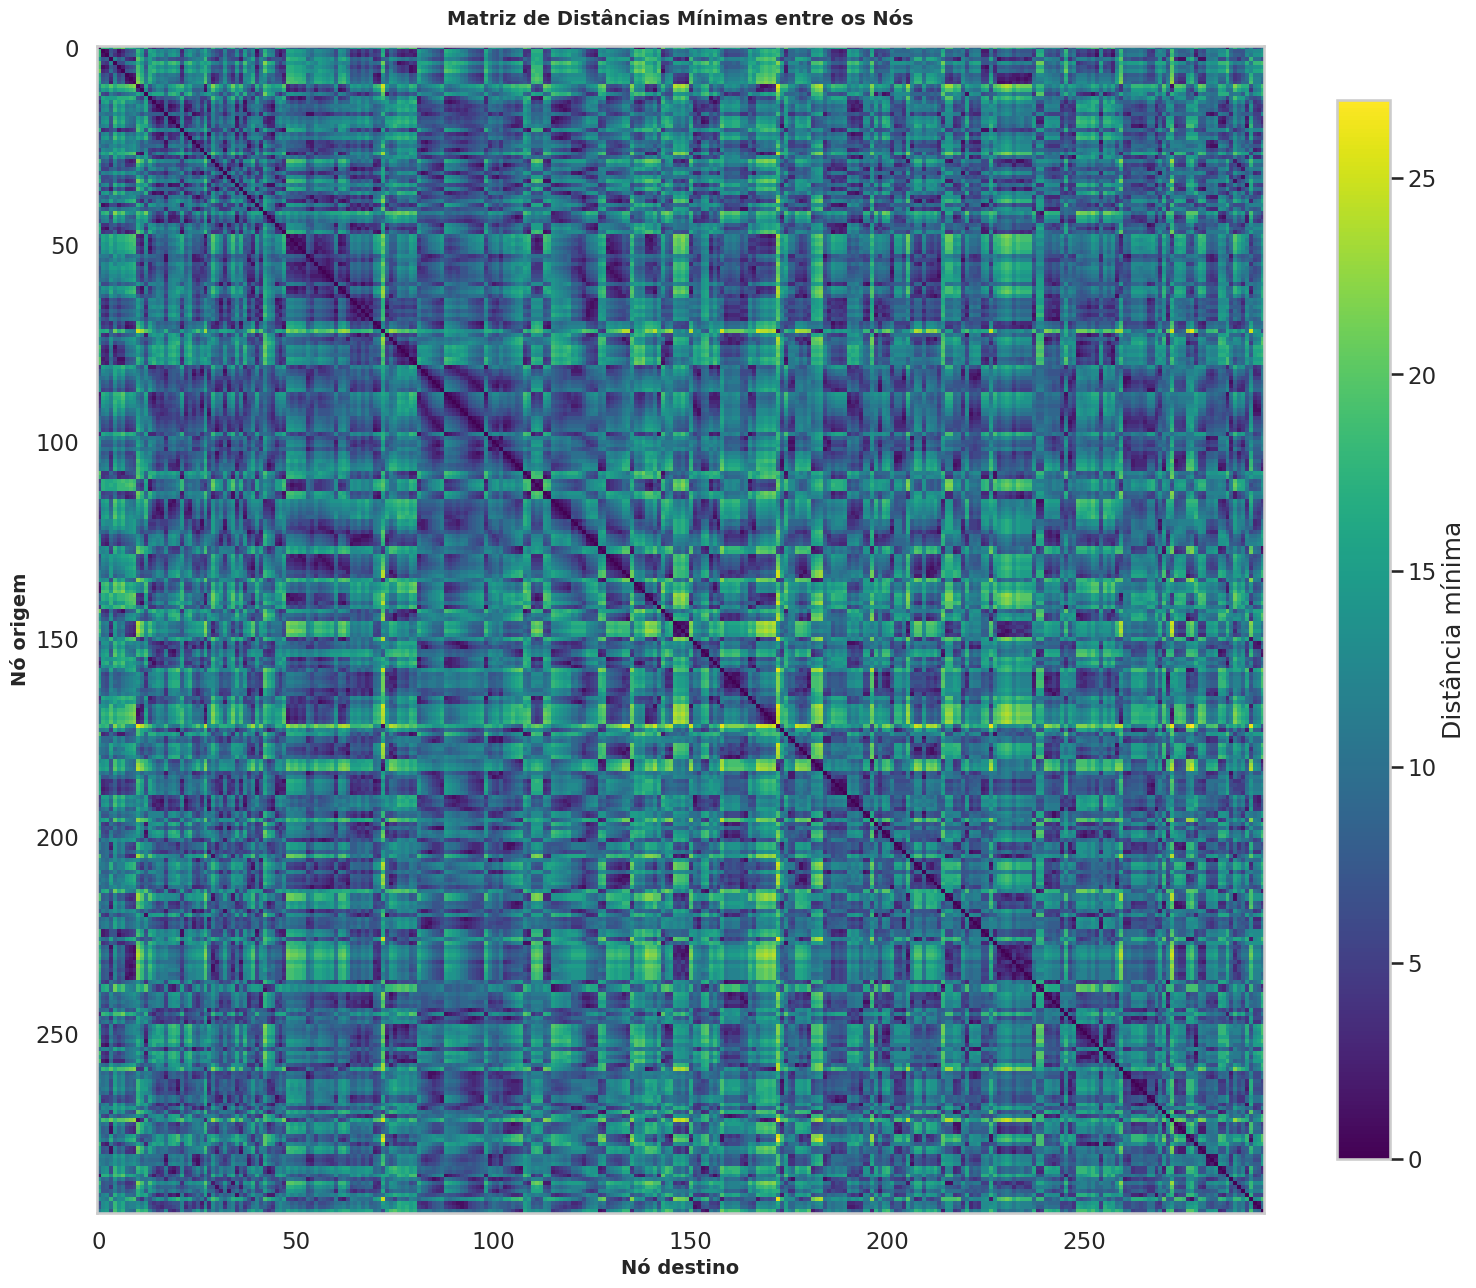

In [25]:
## vamos plotar as distâncias 
plt.figure(figsize=(16, 14))
plt.imshow(matriz_D, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Distância mínima', shrink=0.8)


plt.title('Matriz de Distâncias Mínimas entre os Nós', fontsize=14, pad=15, weight='bold')
plt.xlabel('Nó destino', fontsize=14, weight='bold')
plt.ylabel('Nó origem', fontsize=14, weight='bold')
plt.xticks(np.arange(0, N, 50))
plt.yticks(np.arange(0, N, 50))
plt.grid(False)
plt.tight_layout()
plt.show()

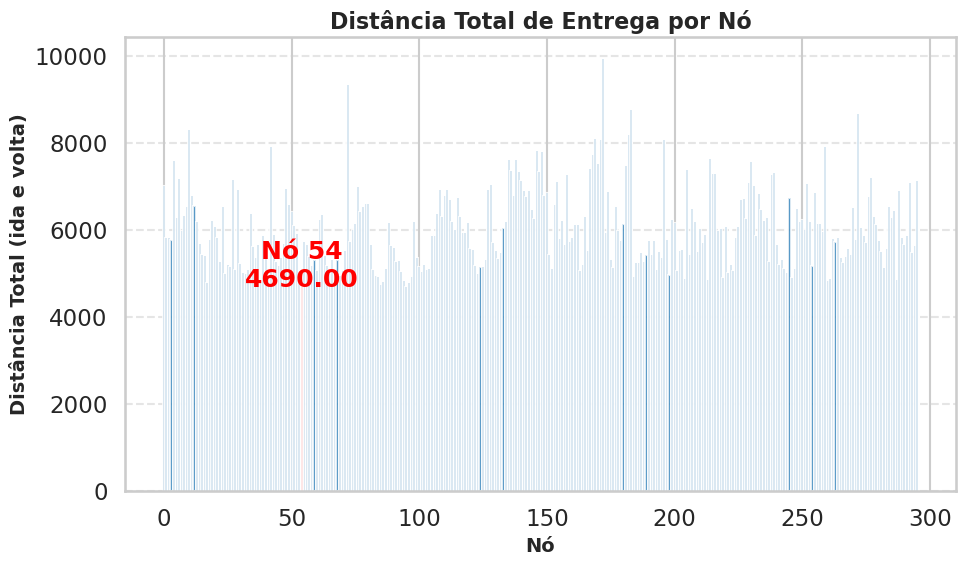

In [27]:
### agora queremos saber qual nó é o ideal para ser o centro de distribuição
### isto é, digamos que você sai do centro de distribuição e precisa entregar em 
### um determinado nó. Você sai do centro de distribuição, realiza a entrega e retorna.
### Qual nó mais eficiente, isto é, o que minimaliza a distância percorrida para realizar 
### entregas em todos os nós?

def no_ideal_logistica(matriz_distancias):
    distancias_cada_no = np.zeros(len(matriz_distancias))
    for i in range(len(matriz_distancias)):
        distancias_cada_no[i] = 2 * np.sum(matriz_distancias[i])
    return distancias_cada_no


# vamos plotar
distancias_cada_no = no_ideal_logistica(matriz_D) #distancias para realizar todas as entregas
nos = np.arange(0, len(matriz_D))

# Encontrar o nó ideal (menor distância total)
no_ideal = np.argmin(distancias_cada_no)
distancia_ideal = distancias_cada_no[no_ideal]


plt.figure(figsize=(10,6))
plt.bar(nos, distancias_cada_no, color='#1f77b4', alpha=0.8)
plt.bar(no_ideal, distancia_ideal, color='red', alpha=0.9)  # nó ideal
plt.text(no_ideal, distancia_ideal + 0.5, f'Nó {no_ideal}\n{distancia_ideal:.2f}', 
         ha='center', color='red', fontweight='bold')
plt.xlabel('Nó', fontsize=14, weight='bold')
plt.ylabel('Distância Total (ida e volta)', fontsize=14, weight='bold')
plt.title('Distância Total de Entrega por Nó', fontsize=16, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


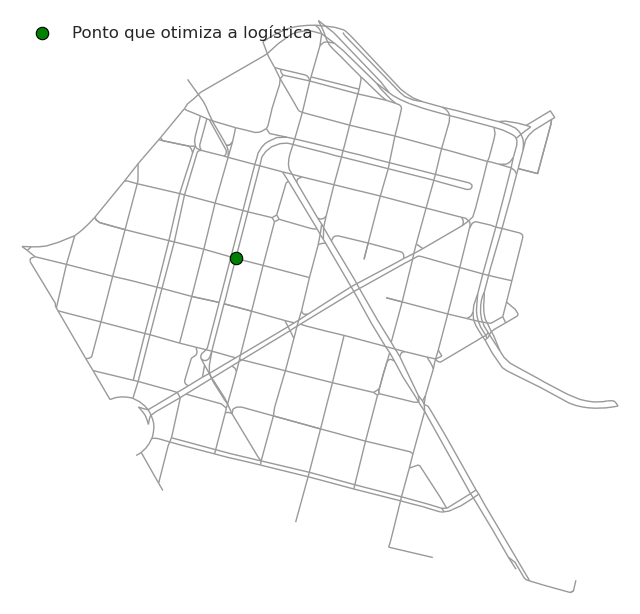

In [56]:
### Sabemos que é o nó 54 que otimiza a logística
### vamos fazer o processo inverso para pegar o ponto real

mapa_inverso = {i: no for no, i in mapa_nos.items()}

indice = 54  # nó que otimiza
id_original = mapa_inverso[indice]  # ID do nó no OpenStreetMap

# Agora pegamos as coordenadas originais
x = G.nodes[id_original]['x']
y = G.nodes[id_original]['y']


# Vamos ver o local ideal no mapa
fig, ax = ox.plot_graph(G, node_size=0, bgcolor="white", show=False, close=False)
ax.scatter(
    x, y,
    c = 'green',
    s = 80,
    zorder = 5,
    edgecolors = 'black',
    linewidth = 0.8,
    label = "Ponto que otimiza a logística"
)

# Mostra a legenda
ax.legend(loc='upper left', frameon = False, fontsize = 12)


plt.show()


In [49]:
### Vamos descobrir a rua do local ótimo! ###

no_osm = mapa_inverso[54]  # ID OSM original do nó 54

# Pega todas as arestas conectadas a esse nó
edges = G.edges(no_osm, data=True)

# Mostra o nome da primeira rua conectada
for u, v, data in edges:
    if 'name' in data:
        print("Rua associada:", data['name'])
        break

Rua associada: Rua dos Carijós
